
<a href="https://colab.research.google.com/github/kokchun/Machine-learning-AI22/blob/main/Exercises/E00_linear_regression.ipynb" target="_parent"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; to see hints and answers.

---
# Linear regression exercises

---
These are introductory exercises in Machine learning with focus in **linear regression** .

<p class = "alert alert-info" role="alert"><b>Note</b> all datasets used in this exercise can be found under Data folder of the course Github repo</p>

<p class = "alert alert-info" role="alert"><b>Note</b> that in cases when you start to repeat code, try not to. Create functions to reuse code instead. </p>

<p class = "alert alert-info" role="alert"><b>Remember</b> to use <b>descriptive variable, function, index </b> and <b> column names</b> in order to get readable code </p>

The number of stars (\*), (\*\*), (\*\*\*) denotes the difficulty level of the task

---

## 0. Simulate phone dataset (*)

We want to simulate data $(x,y)$ to represent cost for phone subscriptions, with: 

- $x$ - called minutes per month
- $y$ - SEK per month 

&nbsp; a) Use ```numpy.random.normal()``` to simulate a dataset with the following requirements:(*)
- set a seed to 42 (for reproducibility and reference)
- simulate 400 x-values from the r.v. $X \sim \mathcal{N}(100, 100)$ 
- take absolute value of these x-values
- simulate noise 400 noise values from r.v. $\epsilon \sim \mathcal{N(0, 50)}$ 
- Let $y = 2x+25+\epsilon$
- plot the data set 

&nbsp; b) Now we want to remove some outliers according to this assumption: (*)
- no one talks more than 300 min using this type of subscription
- no ones costs can be negative
- plot the new dataset
- also plot ground truth using the true parameters $\beta_0 = 25, \beta_1 = 2$

&nbsp; c) Insert the values into a DataFrame (*)

<details>

<summary>Answer</summary>

<img src="../assets/simulated_phone_dataset_0.png" height="200"/>

a) 

Number of points x ≥ 300 min: 8

Number of points y < 0 kr: 6


b)

Length of x, outliers removed 386

Length of y, outliers removed 386

c)

df.head()

|    |   Minutes |     Cost |
|---:|----------:|---------:|
|  0 |   59.4428 | 168.721  |
|  1 |   40.0625 |  98.2118 |
|  2 |  100.524  | 258.433  |
|  3 |  104.698  | 310.548  |
|  4 |   54.9935 | 123.279  |


</details>

---

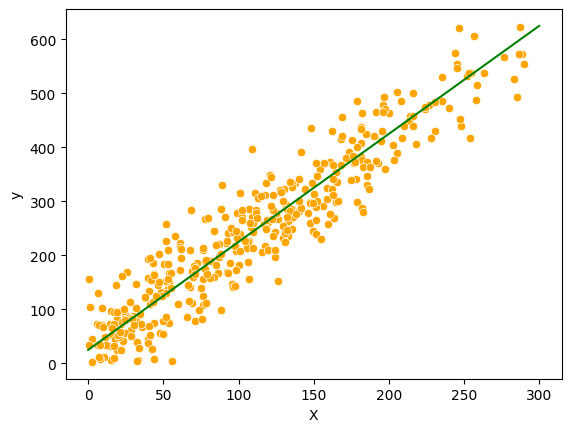

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
X = np.random.normal(100,100, 400)
X = np.abs(X)
e = np.random.normal(0,50, 400)
y = 2 * X + 25 + e
X_truth = np.linspace(0,300)
y_truth = 2 * X_truth + 25
phone = pd.DataFrame({"y": y,
                      "X": X})

phone = phone[(phone["X"] < 300) & (phone["y"] >= 0)]

sns.scatterplot(data=phone, x="X", y="y", color="orange")
sns.lineplot(x=X_truth, y=y_truth, color="green")
plt.show()

## 1. Train|test split (*)

Before moving on with linear regression we shall first perform a train-test-split. 

&nbsp; a) Create a train-test-split function with the following call signature: (*)

```py
def train_test_split(X: pd.DataFrame, y: pd.DataFrame, train_fraction=.7: float, random_state=42: int, replace=False: bool) -> tuple
```

that returns the tuple:
```
(X_train, X_test, y_train, y_test)
```

&nbsp; b) Now use this to split up your data into a training set and test set. Check manually that the split is performed correctly. (*)


<details>

<summary>Hint</summary>

b) Check the length of each set, and check the indices of the sorted sets that they don't overlap and are not missing. Also check that they sum up to what you expect.

</details>

<br/>

<details>

<summary>Answer</summary>

Using default 0.7: 
- length of X_train: 270
- length of X_test: 116
- length of y_train: 270
- length of X_test: 116

</details>

---

In [23]:
def train_test_split(X, y, train_fraction=0.7, random_state=42, replace=False):

    train_n = int(len(X) * train_fraction)
    
    X_train = X.sample(n=train_n, random_state=random_state, replace=replace)
    y_train = y.sample(n=train_n, random_state=random_state, replace=replace)
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    X_train.columns, X_test.columns = ["X"], ["X"]
    y_train.columns, y_test.columns = ["y"], ["y"]

    X_train.insert(0, "Intercept", 1)
    X_test.insert(0, "Intercept", 1)

    return (X_train, X_test, y_train, y_test)


phone_X = pd.DataFrame(phone["X"])
phone_y = pd.DataFrame(phone["y"])

tupp: tuple = train_test_split(phone_X, phone_y)

tupp = tuple(df.sort_index(axis=0) for df in tupp)
ti_list = [df.index.to_list() for df in tupp]
duplicates_X = [i for i in tupp[0] if i in tupp[1]]
duplicates_y = [i for i in tupp[2] if i in tupp[3]]
print(duplicates_X, duplicates_y)
for i, j in enumerate(tupp):
    print(len(tupp[i]))

['Intercept', 'X'] ['y']
266
115
266
115


## 2. Simple linear regression with normal equation (*)

Use the normal equation for simple linear regression to solve for the coefficients $\hat{\beta} = (\beta_0, \beta_1)$. Note that you should only use the training data to fit the regression line, and not data from the test set. Plot the the regression line, together with ground truth and training data. 

<details>

<summary>Hint</summary>

It is important to keep track of the shapes of the vectors, matrices in order for matrix multiplication matmul "@" to work correctly. Also, if you have series object, you need to convert it to numpy. 

</details>

<br/>

<details>

<summary>Answer</summary>


<img src="../assets/Reg_line_normal_eq.png" height="200"/>

</details>

---

Intercept beta_0 hat: 32.2215
Slope beta_1 hat: 1.9105


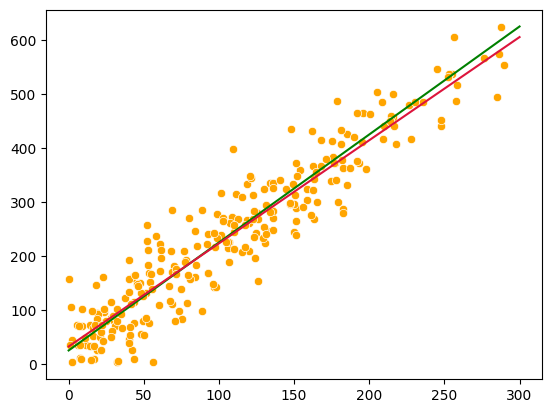

In [24]:
X_train, X_test, y_train, y_test = train_test_split(phone_X, phone_y)

def array_flatten(X_train, X_test, y_train, y_test):
    X_train, X_test = X_train.drop("Intercept", axis="columns"), X_test.drop("Intercept", axis="columns")
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
    X_train, X_test, y_train, y_test = X_train.flatten(), X_test.flatten(), y_train.flatten(), y_test.flatten()
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = array_flatten(X_train, X_test, y_train, y_test)

beta_1, beta_0 = np.polyfit(X_train, y_train, deg=1)
y_hat = lambda x: beta_0 + beta_1 * x

print(f"Intercept beta_0 hat: {beta_0:.4f}")
print(f"Slope beta_1 hat: {beta_1:.4f}")

sns.scatterplot(x=X_train, y=y_train, color="orange")
sns.lineplot(x=X_truth, y=y_truth, color="green")
sns.lineplot(x=X_truth, y=y_hat(X_truth), color="crimson")
plt.show()

<Axes: >

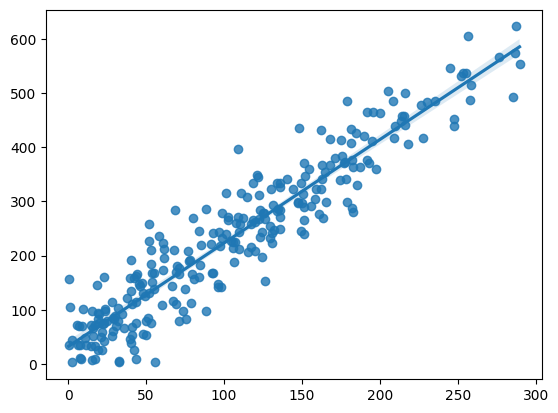

In [25]:
sns.regplot(x=X_train, y=y_train)

## 3. Prediction and evaluation (*)

&nbsp; a) Use your model to make prediction on testing data. Plot the prediction cost against X_test, and y_test against X_test. (*)

&nbsp; b) Calculate MAE, MSE, RMSE (*)

<details>

<summary>Hint</summary>

Calculate y_pred from X_test and use y_test and y_pred to compute different evaluation metrics.

Careful with dimensions when computing the evaluation metrics, else it can be catastrophical logical errors due to numpy broadcasting feature.

Note that after you have calculate the error metrics on test data you are not allowed to change any parameters to make the line fit better to the testing data.

</details>

<br/>

<details>

<summary>Answer</summary>

a) 

<img src="../assets/eval_simple_lin_reg.png" height="200"/>

b)

Mean absolute error on testing data: 36.97 kr

Mean squared error on testing data: 2374 kr^2

Root mean squared error on testing data: 48.72 kr

</details>

---

In [ ]:
# # Make predictions on the testing data
# y_pred = beta_0 + beta_1 * X_test["X"]

# # Plot the prediction cost against X_test, and y_test against X_test
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=X_test["X"], y=y_test["y"], color="blue", label="Actual")
# sns.lineplot(x=X_test["X"], y=y_pred, color="red", label="Predicted")
# plt.xlabel("X_test")
# plt.ylabel("Cost")
# plt.title("Prediction Cost vs Actual Cost")
# plt.legend()
# plt.show()

Mean absolute error: 40.12
Mean squared error: 2401.58
Root mean square error: 49.01


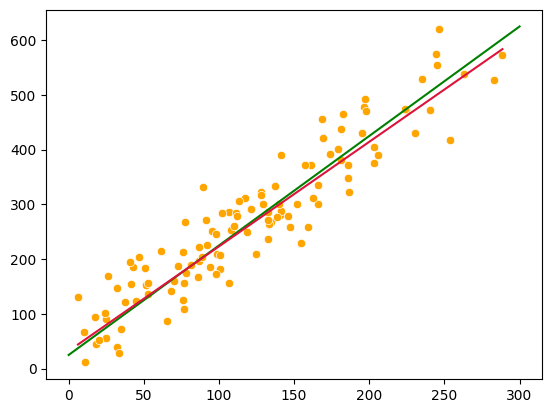

In [42]:
test_line = np.linspace(0, X_test.max())

sns.scatterplot(x=X_test, y=y_test, color="orange")
sns.lineplot(x=X_truth, y=y_truth, color="green")
sns.lineplot(x=X_test, y=y_hat(X_test), color="crimson")

m = len(y_test)
y_pred = y_hat(X_test)
y_pred = np.reshape(y_pred, (m))  # removes the extra dimension

MAE = 1 / m * np.sum(np.abs(y_test - y_pred))
MSE = 1 / m * np.sum((y_test - y_pred) ** 2)
RMSE = np.sqrt(MSE)

for metric in [
    ("Mean absolute error", "MAE"),
    ("Mean squared error", "MSE"),  
    ("Root mean square error", "RMSE"),
]:
    print(f"{metric[0]}: {eval(metric[1]):.2f}")


## 4. Simulate more explanatory variables (\*)

Now we will simulate the explanatory variables for minutes, text messages and amount of surf. For reference and reproducibility use numpy random seed 42. Assume there is:

- mean start cost: 25kr
- mean cost per minute: 2kr
- mean cost per sms: 50 öre
- mean cost per GB: 50kr

Then the model for the cost will be:
$y = 25 + 2x_1 + 0.5x_2 + 50x_3 + \epsilon$, where

- $x_i$ sampled from r.v. $X_i$ for $i = \{1,2,3\}$
- $X_1 \sim |\mathcal{N}(100,100)|$, (absolute value)
- $X_2 \sim \mathcal{U}(0,50)$, (discrete uniform distribution)
- $X_3 \sim |\mathcal{N}(0,2)|$,
- $\epsilon \sim \mathcal{N}(0,50)$

&nbsp; a) Simulate 10000 samples of each of $x_1, x_2, x_3$ and $y$ and save them in a DataFrame. Also add an intercept column containing ones. (\*)

&nbsp; b) Make histograms for each of the explanatory variables $x_1, x_2, x_3$ and the response variable $y$ (\*)

&nbsp; c) Clean the data using the following constraints (\*)

- surf should be less than 4
- minutes should be less than 300
- cost should be larger than 0

&nbsp; d) Make new histograms for the variables. (\*)

<details>

<summary>Hint</summary>
Your data analysis skill toolbox together with statistics and linear algebra skills are getting quite handy here.

</details>

<br/>

<details>

<summary>Answer</summary>

a)

|      | Intercept | Minutes | SMS | Surf (GB) |    Cost |
| ---: | --------: | ------: | --: | --------: | ------: |
|    0 |         1 | 149.671 |  41 |   2.26301 | 502.396 |
|    1 |         1 | 86.1736 |  16 | 0.0315695 | 179.072 |
|  ... |       ... |     ... | ... |       ... |     ... |
| 9318 |         1 | 149.577 |  31 |   3.43929 | 536.176 |
| 9319 |         1 | 164.439 |  43 |   1.40641 | 406.674 |

b)

<img src="../assets/hist_variables.png" height="200"/>

d)

<img src="../assets/hist_var_cleaned.png" height="200"/>

</details>

---


## 5. Multiple linear regression (*)

&nbsp; a) Perform a train|test split with 0.8 of the data for training. (*)

&nbsp; b) Use the normal equation to compute $\hat{\beta}$ (*)

&nbsp; c) Predict on the test data and compute MAE, MSE and RMSE. (*)

&nbsp; d) Now repeat 4a), 4c), 5a), 5b) using 10, 100, 1000, 10000, 100000, 1000000 samples, and calculate RMSE for each of these simulations. Plot the RMSE against sample size. (**)


<details>

<summary>Hint</summary>

It is important to keep track of the shapes of the vectors, matrices in order for matrix multiplication matmul "@" to work correctly. Also, if you have series object, you need to convert it to numpy. 

</details>

<br/>

<details>
<summary>Answer</summary>


<img src="../assets/RMSE_simulation.png" height="200"/>

</details>

---

Kokchun Giang

[LinkedIn][linkedIn_kokchun]

[GitHub portfolio][github_portfolio]

[linkedIn_kokchun]: https://www.linkedin.com/in/kokchungiang/
[github_portfolio]: https://github.com/kokchun/Portfolio-Kokchun-Giang

---